## **HOMEWORK 2.2: International Flight Route Optimization** <br> <br>

Implement A* for a flight network where:<br>
- Nodes are cities (with latitude/longitude)
- Edges are flights (with actual flight times in minutes)
- Heuristic is based on geographic distance

In [1]:
import math
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from matplotlib.patches import FancyArrowPatch

In [2]:
# City coordinates (latitude, longitude)
cities = {
    "London": (51.5074, -0.1278),
    "Paris": (48.8566, 2.3522),
    "Berlin": (52.5200, 13.4050),
    "Madrid": (40.4168, -3.7038),
    "Rome": (41.9028, 12.4964),
    "Amsterdam": (52.3676, 4.9041),
    "Vienna": (48.2082, 16.3738),
    "Prague": (50.0755, 14.4378),
    "Copenhagen": (55.6761, 12.5683),
    "Stockholm": (59.3293, 18.0686),
    "Milan": (45.4642, 9.1900),
    "Barcelona": (41.3851, 2.1734),
    "Munich": (48.1351, 11.5820),
    "Zurich": (47.3769, 8.5417),
    "Brussels": (50.8503, 4.3517)
}

# Flight connections with actual flight times (in minutes)
# Format: (origin, destination, flight_time_minutes)
flights = [
    ("London", "Paris", 80),
    ("London", "Amsterdam", 75),
    ("London", "Brussels", 70),
    ("London", "Madrid", 150),
    ("Paris", "Brussels", 50),
    ("Paris", "Madrid", 130),
    ("Paris", "Barcelona", 110),
    ("Paris", "Rome", 135),
    ("Paris", "Zurich", 90),
    ("Berlin", "Amsterdam", 90),
    ("Berlin", "Prague", 70),
    ("Berlin", "Copenhagen", 75),
    ("Berlin", "Vienna", 90),
    ("Berlin", "Munich", 65),
    ("Madrid", "Barcelona", 80),
    ("Madrid", "Rome", 160),
    ("Rome", "Milan", 75),
    ("Rome", "Vienna", 110),
    ("Amsterdam", "Brussels", 45),
    ("Amsterdam", "Copenhagen", 95),
    ("Amsterdam", "Munich", 85),
    ("Vienna", "Prague", 70),
    ("Vienna", "Munich", 75),
    ("Vienna", "Zurich", 90),
    ("Prague", "Munich", 65),
    ("Copenhagen", "Stockholm", 70),
    ("Milan", "Zurich", 60),
    ("Milan", "Munich", 70),
    ("Barcelona", "Milan", 110),
    ("Barcelona", "Zurich", 115),
    ("Munich", "Zurich", 60),
    ("Brussels", "Munich", 85)
]



In [3]:
#Build the flight network graph
def build_flight_graph(flights):
    G = {}

    for origin, dest, time in flights:
        if origin not in G:
            G[origin] = {}

        if dest not in G:
            G[dest] = {}
        
        #Create a bidirectional connection
        G[origin][dest] = time
        G[dest][origin] = time
    
    return G

flight_graph = build_flight_graph(flights)


In [4]:
#Haversine distance calculation: it's the grate -circle distance between two points on Earth
def haversine(lat1, lon1, lat2, lon2):
    
    #Earth's radius in Km
    R = 6731

    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    return R * c


#Heuristic functions for flight routing

def h_zero(city, goal, cieties):
    return 0

#Haversine distance / max_speed
#Converts distance to time using the max commercial jet speed (950 km/h)
def h_admissible(city, goal, cities):
    max_speed = 950

    lat1, lon1 = cities[city]
    lat2, lon2 = cities[goal]

    h = haversine(lat1, lon1, lat2, lon2)

    return h / max_speed * 60

#Haversine distance / slower_speed
#Converts distance to time using a slower speed (500 km/h)
def h_aggressive(city, goal, cities):
    slower_speed = 500

    lat1, lon1 = cities[city]
    lat2, lon2 = cities[goal]

    h = haversine(lat1, lon1, lat2, lon2)

    return h / slower_speed * 60  

    

In [6]:
def astar_flights(source, target, heuristic):
    g_score = {source: 0}
    f_score = {source: heuristic(source, target, cities)}

    parent = {source: None}
    total_time = 0
    
    open = []
    heapq.heappush(open, (0, source))

    closed = set()

    while open:
        _, current = heapq.heappop(open)

        if current in closed:
            continue

        closed.add(current)

        if current == target:
            path = []
            while current:
                path.append(current)
                temp = parent[current]
                if temp is not None:
                    total_time += flight_graph[current][temp]

                current = temp

            path.reverse()
            
            return path, total_time, closed
        
        neighbors = flight_graph[current]

        for neighbor in neighbors:

            if neighbor in closed:
                continue

            temp_g = g_score[current] + flight_graph[current][neighbor]

            h = heuristic(neighbor, target, cities)

            temp_f = temp_g + h

            if neighbor not in g_score or temp_g < g_score[neighbor]:
                parent[neighbor] = current
                g_score[neighbor] = temp_g
                f_score[neighbor] = temp_f

                if neighbor not in open:
                    heapq.heappush(open, (f_score[neighbor], neighbor))
   
    return None, float('inf'), set()



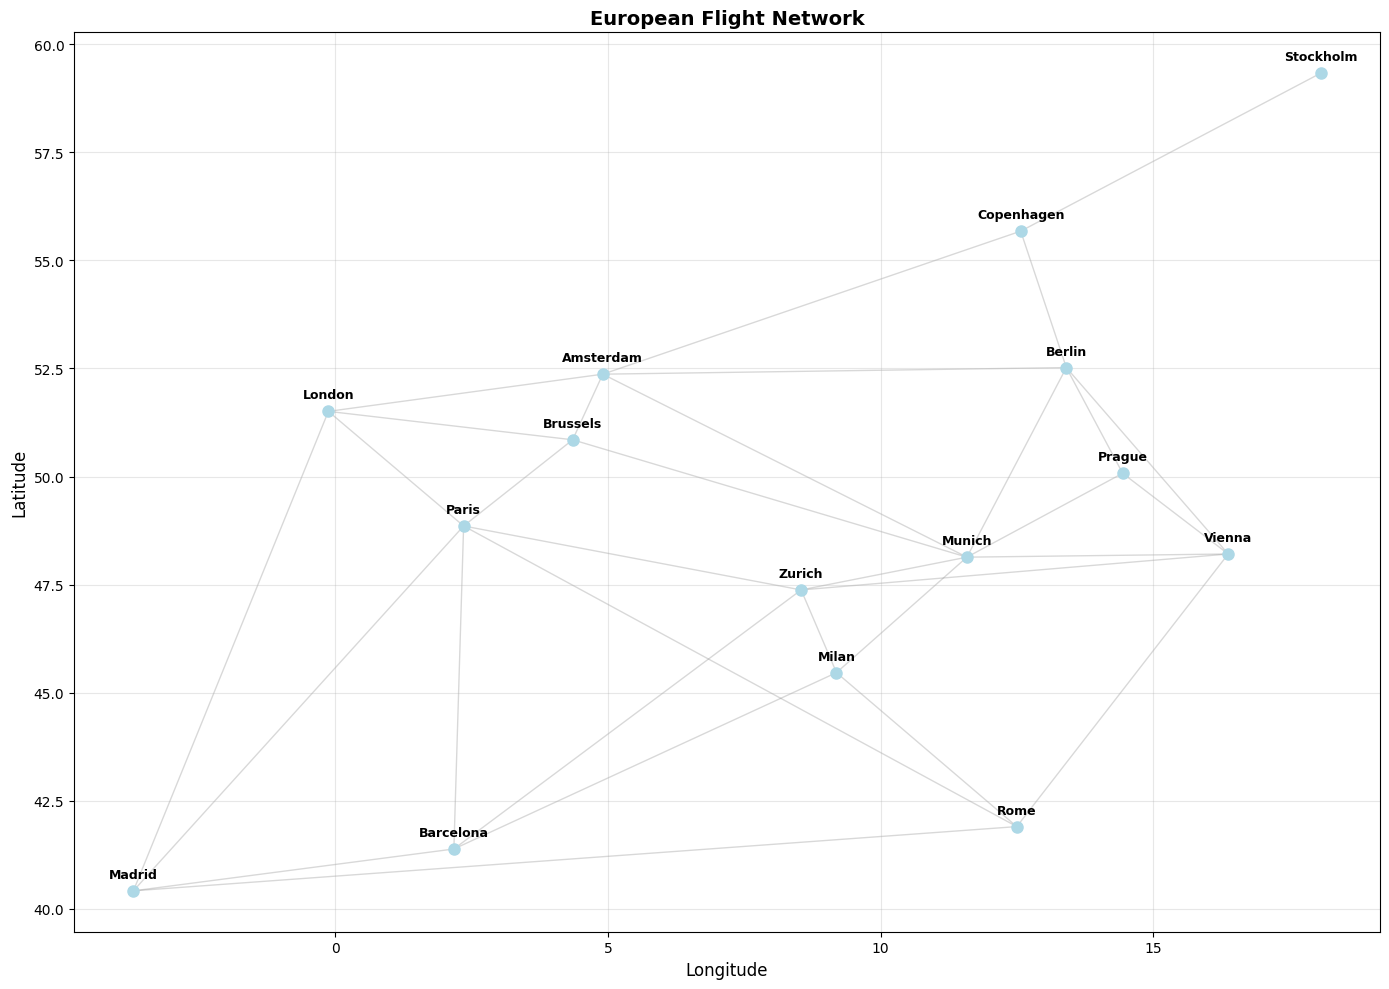

In [7]:
# Visualize the flight network
def visualize_flight_network(cities, flights, path=None, title="European Flight Network"):
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Plot all cities
    for city, (lat, lon) in cities.items():
        ax.plot(lon, lat, 'o', markersize=8, color='lightblue', zorder=2)
        ax.text(lon, lat + 0.3, city, fontsize=9, ha='center', fontweight='bold')
    
    # Plot all flights in gray
    for origin, dest, _ in flights:
        lat1, lon1 = cities[origin]
        lat2, lon2 = cities[dest]
        ax.plot([lon1, lon2], [lat1, lat2], 'gray', alpha=0.3, linewidth=1, zorder=1)
    
    # Highlight path if provided
    if path:
        for i in range(len(path) - 1):
            lat1, lon1 = cities[path[i]]
            lat2, lon2 = cities[path[i+1]]
            ax.annotate('', xy=(lon2, lat2), xytext=(lon1, lat1),
                       arrowprops=dict(arrowstyle='->', color='red', lw=3, alpha=0.8),
                       zorder=3)
        
        # Highlight cities in path
        for city in path:
            lat, lon = cities[city]
            ax.plot(lon, lat, 'o', markersize=12, color='red', zorder=4)
    
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Show the flight network
visualize_flight_network(cities, flights)

In [8]:
def test_heuristics(start, target):
    heuristics = [h_zero, h_admissible, h_aggressive]
    
    for heuristic in heuristics:
        path, time, expanded = astar_flights(start, target, heuristic)

        h_name = ""

        if heuristic is h_admissible:
            h_name = "Admissible Heuristic"
        elif heuristic is h_aggressive:
            h_name = "Aggressive Heuristic"
        elif heuristic is h_zero:
            h_name = "No Heuristic"

        title = h_name + " | from " + start + " to " + target + " | Total time = " + str(time) + " | Expandend nodes = " + str(len(expanded))
 
        visualize_flight_network(cities, flights, path, title)




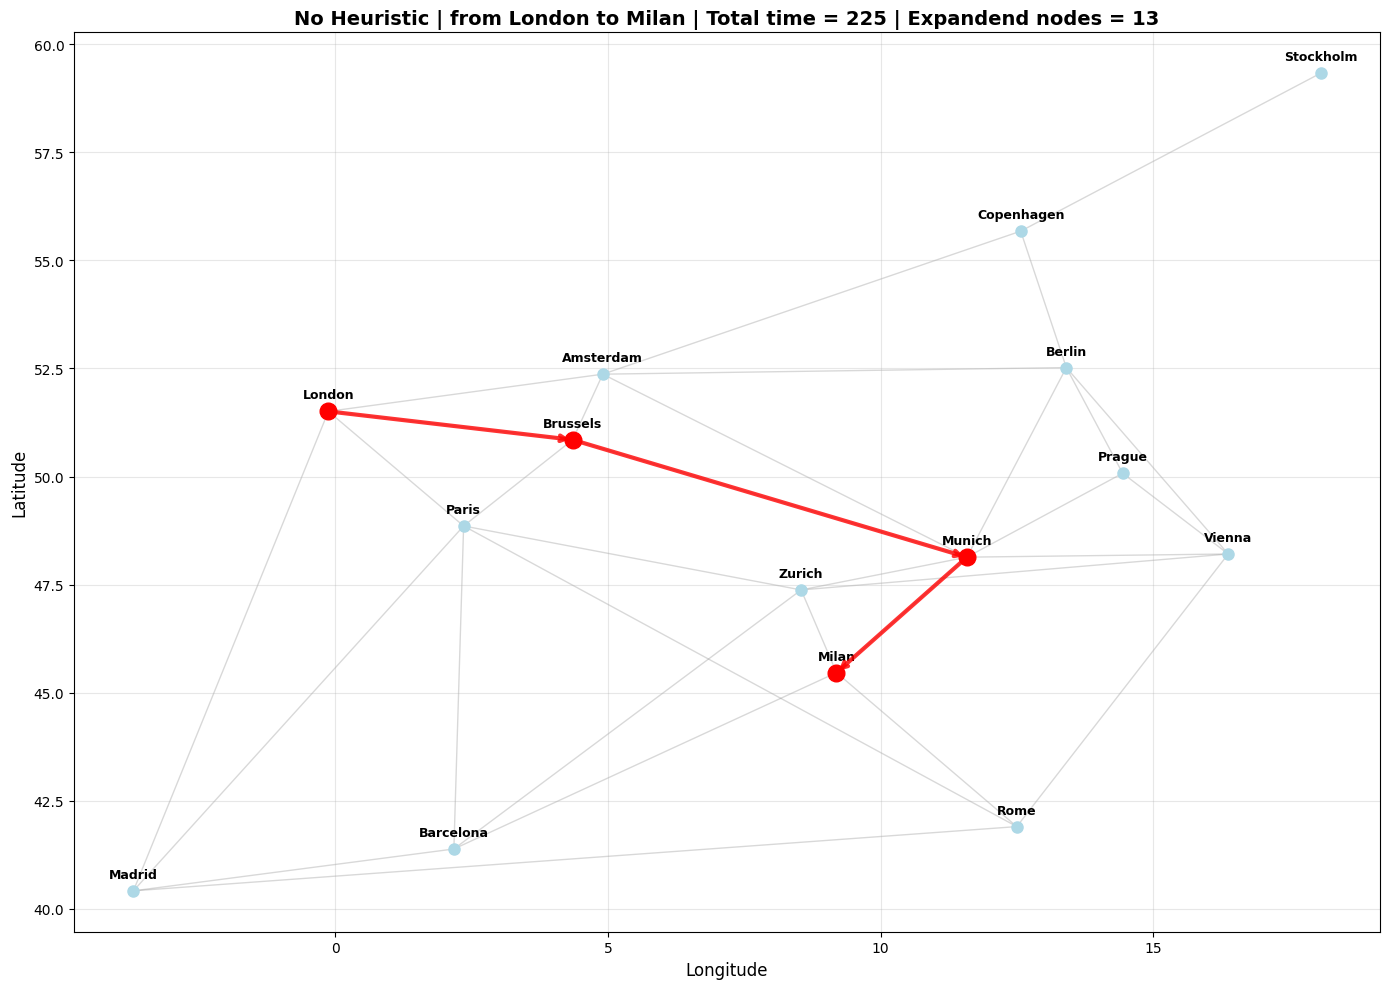

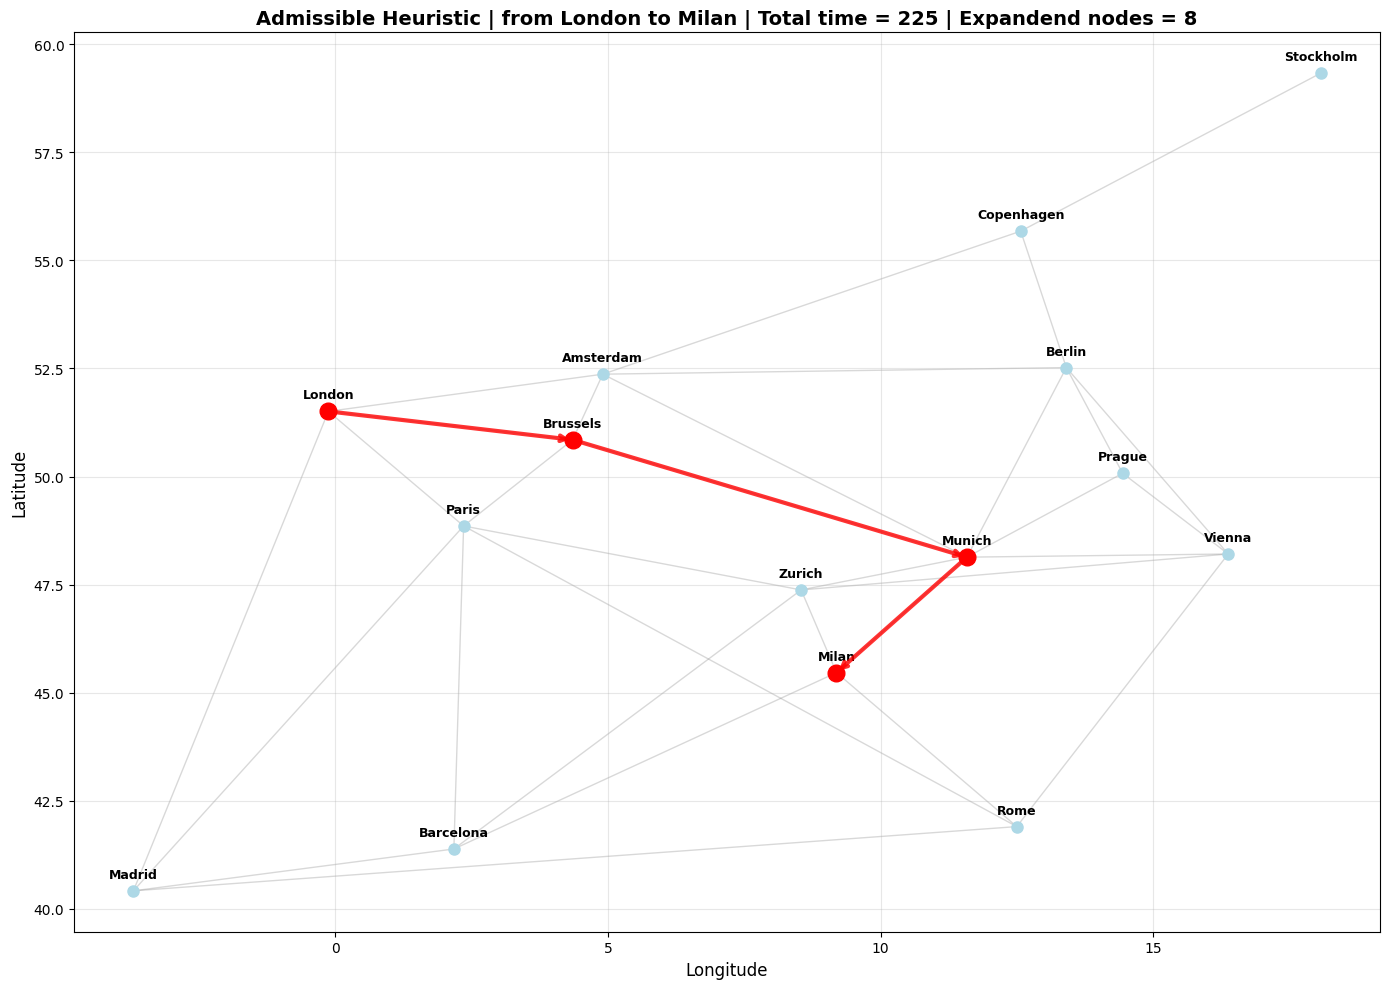

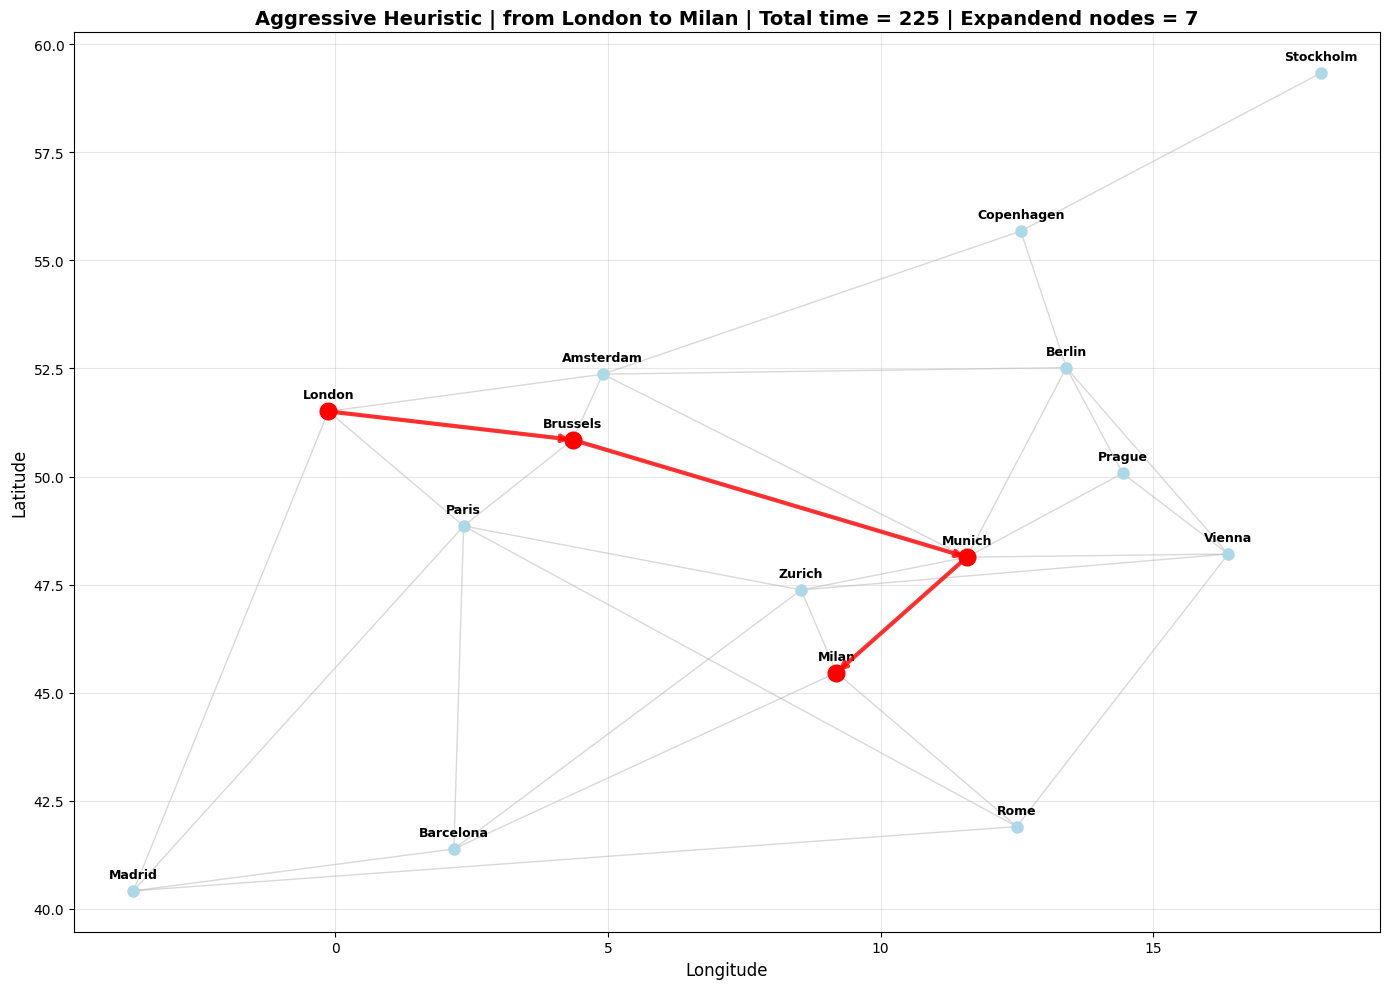

In [9]:
test_heuristics("London", "Milan")

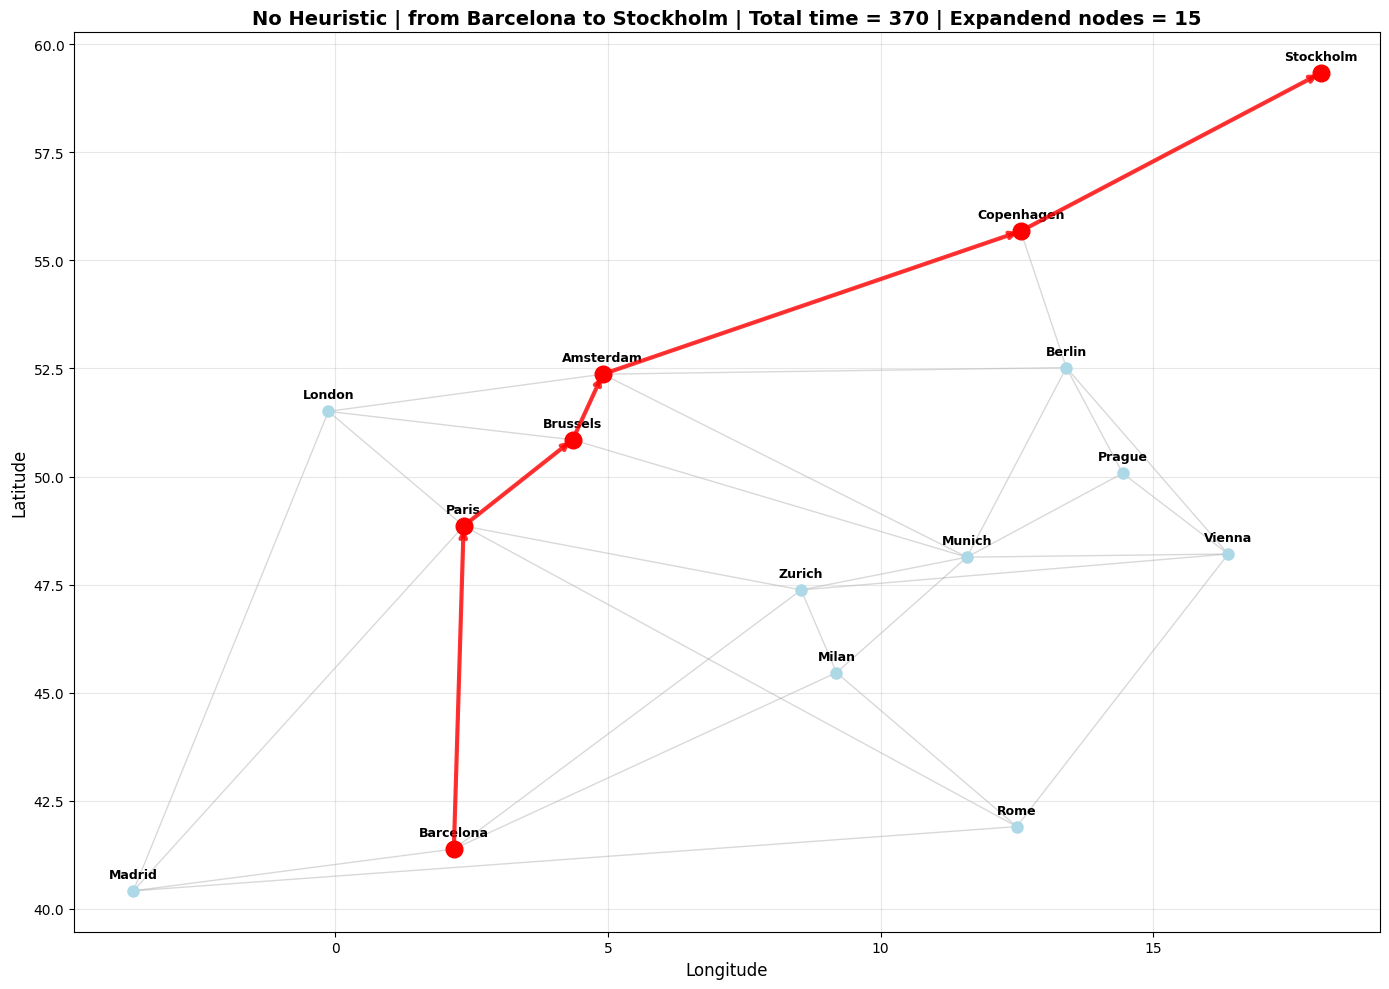

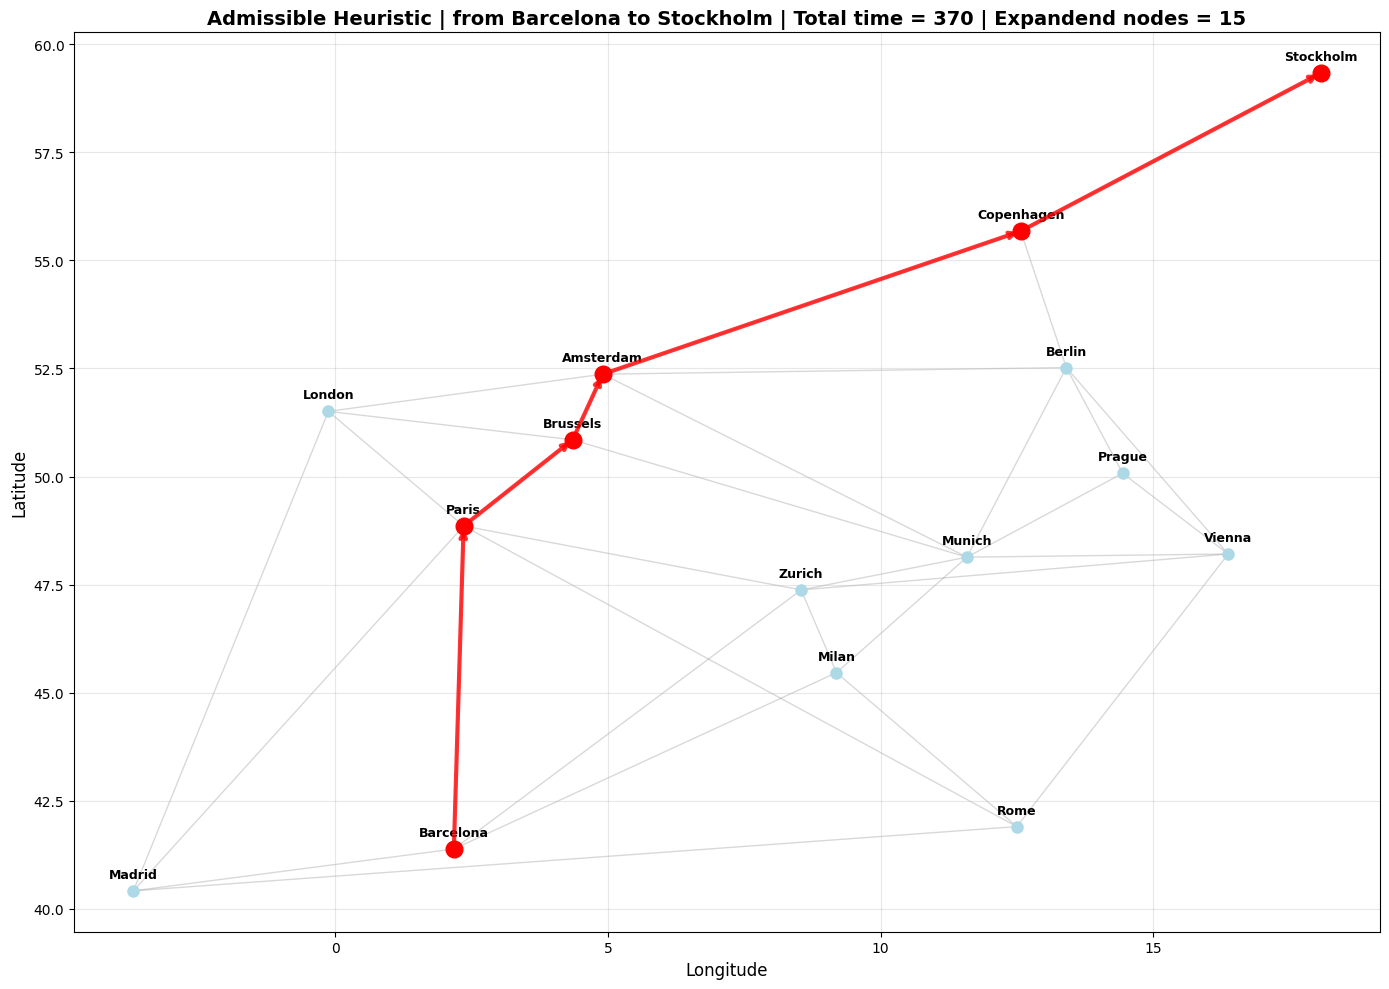

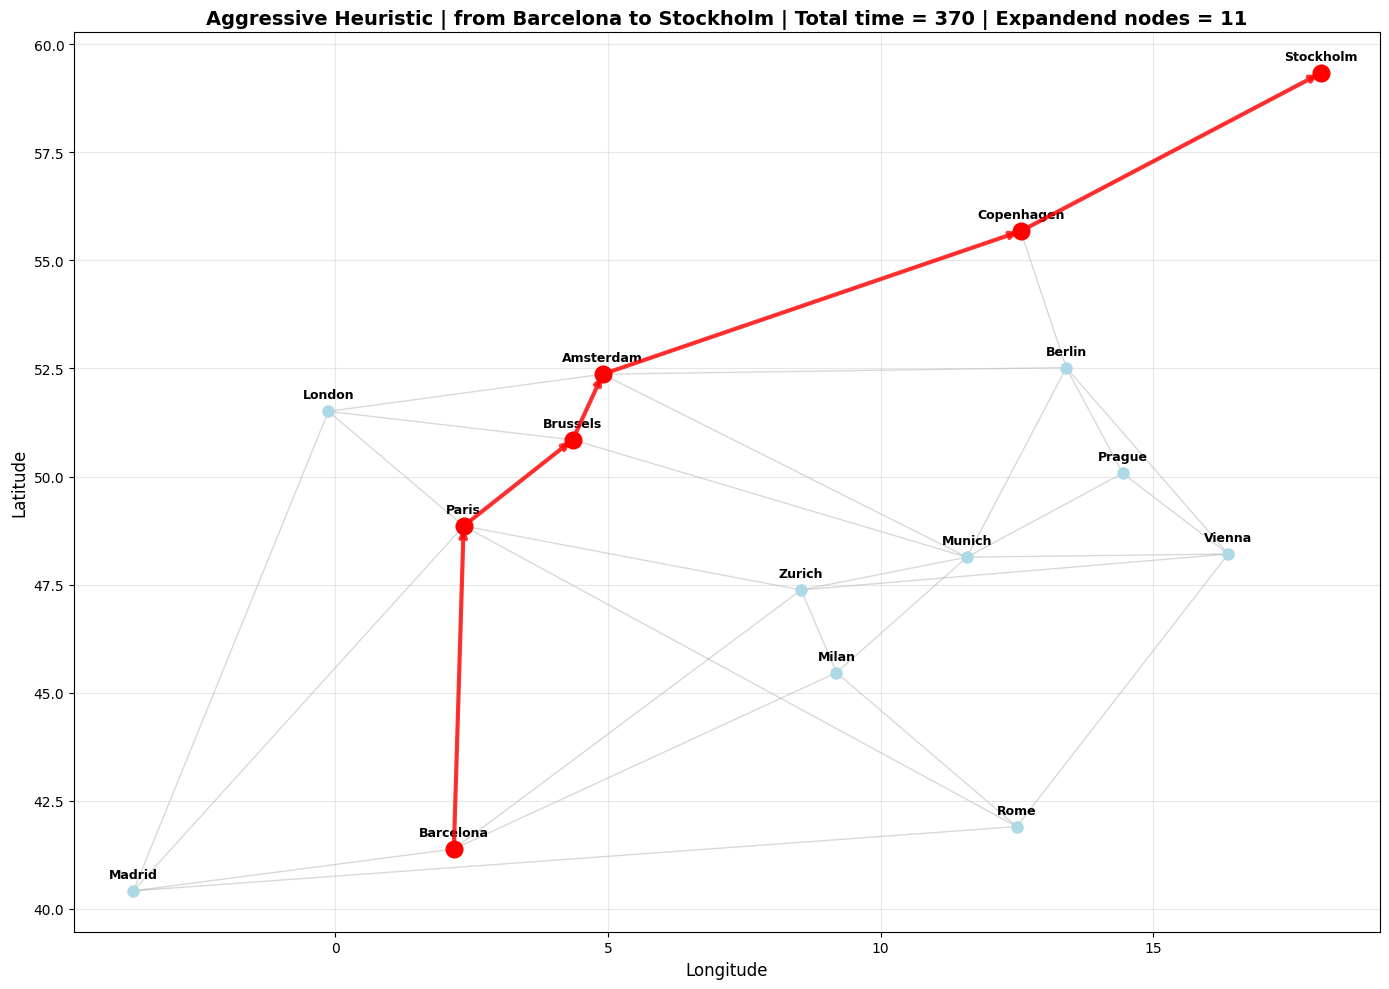

In [10]:
test_heuristics("Barcelona", "Stockholm")